In [84]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [85]:
cuda = torch.cuda.is_available() #GPU
batch_size = 32
epochs2 = 50

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [86]:
#global setting
T = 500
# beta = np.linspace(0.01, 0.03, T)
beta = 0.01*np.ones((T,))
alpha = 1 - beta
alpha_bar = np.cumprod(alpha,0)
sqrt_alpha_bar = np.sqrt(alpha_bar)

def forward_process(x_0, t):
    noise = np.random.multivariate_normal(np.zeros(28*28),np.eye(28*28)).reshape(28,28) # Sample noise from multivariate normal distribution with same size of X_0
    noise_image = x_0 * sqrt_alpha_bar[t-1] + noise * np.sqrt(1-alpha_bar[t-1])
    return noise, noise_image


In [87]:
t = torch.randint(0,200,(5,1))
alpha_bar[t]

array([[0.62982363],
       [0.2448653 ],
       [0.28470777],
       [0.18295652],
       [0.52559649]])

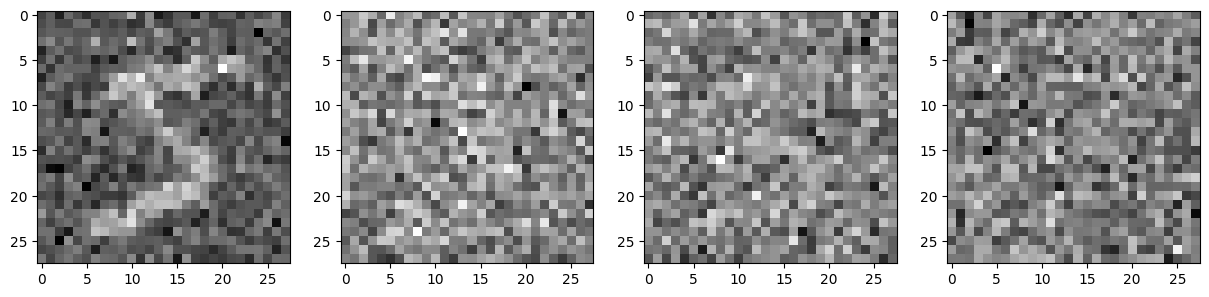

In [88]:
sample_mnist = next(iter(train_loader.dataset))[0]

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([10, 100, 150, 200]):
    noise, noise_image = forward_process(sample_mnist.squeeze(),i)
    plt.subplot(1, 4, index+1)
    plt.imshow(noise_image.squeeze(), cmap='gray')
plt.savefig("diffusion1")   
plt.show()

Text(0.5, 1.0, 'Alphas bar over t')

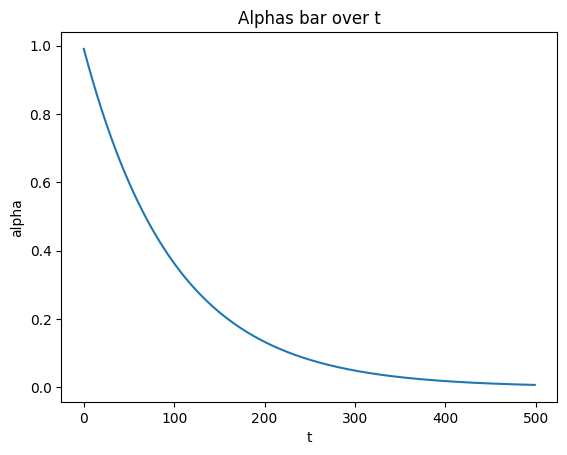

In [89]:
plt.plot(alpha_bar)
plt.ylabel("alpha")
plt.xlabel("t")
plt.title("Alphas bar over t")

In [7]:
beta = torch.from_numpy(beta).to(device).float()
alpha_bar = torch.from_numpy(alpha_bar).to(device).float()

In [74]:
from matplotlib.font_manager import X11FontDirectories
# neural network to learn epsilon(x_t,t). you can pla around with it, but we added it for convenience
# class DDPM(nn.Module):
#     def __init__(self):
#         super(DDPM, self).__init__()
#         self.t_emb_dim = 100
#         self.encConv1 = nn.Conv2d(1, 16, 5)
#         self.encConv2 = nn.Conv2d(16, 32, 5) # output torch size = [128, 32, 20, 20]
#         self.fc1 = nn.Linear(32*20*20, 32)
#         self.fct = nn.Linear(self.t_emb_dim, 32)
#         self.fc3 = nn.Linear(32, 32*20*20)
#         self.decConv1 = nn.ConvTranspose2d(32,16,5)
#         self.decConv2 = nn.ConvTranspose2d(16, 1, 5)

#     def forward(self, x,t):
#         #we use a time-embedding here. neural networks are terrible at working directly with time as a real variable.
#         #we therefore replace it by a set of features t_embedding that just represent several sine waves with different
#         #frequency
#         omegas = 2*np.pi*(torch.arange(self.t_emb_dim) / T).reshape(1,-1).to(device)
#         t_embedding = torch.cos(omegas*t.reshape(-1,1))
#         #Network structure: a simple network with two hidden layers. the first
#         # two fully connected laers are just there to merge the time embedding with the input vector
#         x = F.relu(self.encConv1(x))
#         x = F.relu(self.encConv2(x))
#         x = torch.flatten(x,1)
#         x = F.relu(self.fc1(x)+self.fct(t_embedding))
#         x = F.relu(self.fc3(x))
#         x = x.view(-1,32,20,20)
#         x = F.relu(self.decConv1(x))
#         return torch.sigmoid(self.decConv2(x))

class DDPM(nn.Module):
    def __init__(self):
        super(DDPM, self).__init__()
        self.t_emb_dim = 100
        self.fc1 = nn.Linear(28*28, 1000)
        self.fct = nn.Linear(self.t_emb_dim, 1000)
        self.block = nn.Sequential(nn.Linear(1000, 1000),
                      nn.ReLU(),
                      nn.Linear(1000, 1000),
                      nn.ReLU(),
                      nn.Linear(1000, 28*28))

    def forward(self, x,t):
        #we use a time-embedding here. neural networks are terrible at working directly with time as a real variable.
        #we therefore replace it by a set of features t_embedding that just represent several sine waves with different
        #frequency
        omegas = 2*np.pi*(torch.arange(self.t_emb_dim) / T).reshape(1,-1).to(device)
        t_embedding = torch.cos(omegas * t.reshape(-1,1))
        #Network structure: a simple network with two hidden layers. the first
        # two fully connected laers are just there to merge the time embedding with the input vector
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)+self.fct(t_embedding))
        x = self.block(x)
        return x.view(-1, 1, 28, 28)

# class DDPM(nn.Module):
#     def __init__(self):
#         super(DDPM, self).__init__()
#         self.t_emb_dim = 100
#         self.block1 = nn.Sequential(nn.Conv2d(1, 32, 5, padding=2),
#                       nn.BatchNorm2d(32),
#                       nn.ReLU(),
#                       nn.Conv2d(32, 64, 5, padding=2))
#         self.fct = nn.Linear(self.t_emb_dim, 64)
#         self.block2 = nn.Sequential(nn.BatchNorm2d(64),
#                       nn.ReLU(),
#                       nn.Conv2d(64, 32, 5, padding=2),
#                       nn.BatchNorm2d(32),
#                       nn.ReLU(),
#                       nn.Conv2d(32, 1, 5, padding=2))

#     def forward(self, x,t):
#         omegas = 2*np.pi*(torch.arange(self.t_emb_dim) / T).reshape(1,-1).to(device)
#         t_embedding = torch.cos(omegas*t.reshape(-1,1))
#         x = self.block1(x)
#         x += self.fct(t_embedding).view(-1, 64, 1, 1) # add same value for the whole channel
#         x = self.block2(x)
#         return x

In [75]:
# def loss_f(Xs, model):
#     T= 200
#     beta = torch.linspace(0.0001, 0.02, T)
#     alpha = 1 - beta
#     alpha_bar = torch.cumprod(alpha,0).to(device)

#     batch_size = Xs.size(0)
#     t = torch.randint(0,200,(10,1)).expand(batch_size,10,1).reshape(batch_size*10,1)
#     Xs = Xs.expand(10,batch_size,-1,28,28).reshape(batch_size*10,28*28)
#     epsilon_t = torch.randn(Xs.shape).to(device)
#     X_t = (torch.sqrt(alpha_bar[t])*Xs+torch.sqrt(1-alpha_bar[t])*epsilon_t).reshape(batch_size*10,1,28,28)
#     loss = torch.mean(torch.sum((epsilon_t.reshape(-1,1,28,28)-model(X_t,t))**2,-1))
#     return loss

def loss_f(Xs, model, beta, alpha_bar):
    T= len(beta)
    batch_size = Xs.shape[0]
    t = torch.randint(0,T,(batch_size,1, 1, 1)).to(device)
    epsilon_t = torch.randn(Xs.size()).to(device)
    X_t = torch.sqrt(alpha_bar[t])*Xs + torch.sqrt(1-alpha_bar[t])*epsilon_t
    loss = torch.mean(torch.sum( ((epsilon_t - model(X_t, t))**2).view(batch_size, -1),-1))
    return loss

In [76]:
def train(epoch, beta, alpha_bar):
    model.train() # so that everything has gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader,leave=False)):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        loss = loss_f(data, model, beta, alpha_bar)
        loss.backward() # calc gradients
        # print(torch.linalg.norm(model.fc1.weight.grad))
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.10f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch, beta, alpha_bar):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            test_loss += loss_f(data, model, beta, alpha_bar).item()

    test_loss /= len(test_loader.dataset)
    
    print('====> Test set loss: {:.10f}'.format(test_loss))

In [77]:
model = DDPM().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(1, 50 + 1):
    train(epoch, beta, alpha_bar)
    test(epoch, beta, alpha_bar)

====> Epoch: 1 Average loss: 19.0358752950
====> Test set loss: 14.5818892181


====> Epoch: 2 Average loss: 12.4894440679
====> Test set loss: 10.8420428101


====> Epoch: 3 Average loss: 9.8211469594
====> Test set loss: 8.9609573700


====> Epoch: 4 Average loss: 8.2522399610
====> Test set loss: 7.6287043213


====> Epoch: 5 Average loss: 7.1550265450
====> Test set loss: 6.7789391556


====> Epoch: 6 Average loss: 6.3713589101
====> Test set loss: 6.0769740646


====> Epoch: 7 Average loss: 5.7469616147
====> Test set loss: 5.4969393631


====> Epoch: 8 Average loss: 5.2677364230
====> Test set loss: 5.0746131668


====> Epoch: 9 Average loss: 4.8564066149
====> Test set loss: 4.6854506470


====> Epoch: 10 Average loss: 4.4879638935
====> Test set loss: 4.3695302353


====> Epoch: 11 Average loss: 4.1993143050
====> Test set loss: 4.0739184120


====> Epoch: 12 Average loss: 3.9322952988
====> Test set loss: 3.8448319214


====> Epoch: 13 Average loss: 3.7483874325
====> Test set loss: 3.6616611519


====> Epoch: 14 Average loss: 3.5626360414
====> Test set loss: 3.5104102890


====> Epoch: 15 Average loss: 3.3889437871
====> Test set loss: 3.2786185059


====> Epoch: 16 Average loss: 3.2098415915
====> Test set loss: 3.1495953514


====> Epoch: 17 Average loss: 3.0907611553
====> Test set loss: 2.9620773102


====> Epoch: 18 Average loss: 2.9662598461
====> Test set loss: 2.9377974838


====> Epoch: 19 Average loss: 2.8879985257
====> Test set loss: 2.8254890774


====> Epoch: 20 Average loss: 2.7757030910
====> Test set loss: 2.6995439400


====> Epoch: 21 Average loss: 2.6722731471
====> Test set loss: 2.6558732166


====> Epoch: 22 Average loss: 2.5884713130
====> Test set loss: 2.5590351097


====> Epoch: 23 Average loss: 2.4825258715
====> Test set loss: 2.4558178989


====> Epoch: 24 Average loss: 2.4213281160
====> Test set loss: 2.3931802113


====> Epoch: 25 Average loss: 2.3663709440
====> Test set loss: 2.3731836975


====> Epoch: 26 Average loss: 2.2968065821
====> Test set loss: 2.3116364628


====> Epoch: 27 Average loss: 2.2513155910
====> Test set loss: 2.2222920372


====> Epoch: 28 Average loss: 2.1870004625
====> Test set loss: 2.1583267757


====> Epoch: 29 Average loss: 2.1322066775
====> Test set loss: 2.0938875587


====> Epoch: 30 Average loss: 2.0927655408
====> Test set loss: 2.1093197620


====> Epoch: 31 Average loss: 2.0698964043
====> Test set loss: 2.0816546680


====> Epoch: 32 Average loss: 2.0455354268
====> Test set loss: 2.0269254616


====> Epoch: 33 Average loss: 1.9835850346
====> Test set loss: 1.9130834553


====> Epoch: 34 Average loss: 1.9484081114
====> Test set loss: 1.8466304657


====> Epoch: 35 Average loss: 1.9165558927
====> Test set loss: 1.8864580898


====> Epoch: 36 Average loss: 1.8569369293
====> Test set loss: 1.7673639801


====> Epoch: 37 Average loss: 1.8549072228
====> Test set loss: 1.8194527481


====> Epoch: 38 Average loss: 1.8077752716
====> Test set loss: 1.7628224524


====> Epoch: 39 Average loss: 1.7784459533
====> Test set loss: 1.8019611870


====> Epoch: 40 Average loss: 1.7467592119
====> Test set loss: 1.7568543463


====> Epoch: 41 Average loss: 1.7306063529
====> Test set loss: 1.7225196795


====> Epoch: 42 Average loss: 1.7067861404
====> Test set loss: 1.7072390388


====> Epoch: 43 Average loss: 1.7169683086
====> Test set loss: 1.6605479965


====> Epoch: 44 Average loss: 1.7070973104
====> Test set loss: 1.7063944227


====> Epoch: 45 Average loss: 1.6806585720
====> Test set loss: 1.6445063074


====> Epoch: 46 Average loss: 1.6551129912
====> Test set loss: 1.6730607132


====> Epoch: 47 Average loss: 1.6493645885
====> Test set loss: 1.6657024633


====> Epoch: 48 Average loss: 1.6319121813
====> Test set loss: 1.7021272665


====> Epoch: 49 Average loss: 1.6064678772
====> Test set loss: 1.5692285435


====> Epoch: 50 Average loss: 1.6036544003
====> Test set loss: 1.6404017326


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_37400\1419880940.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


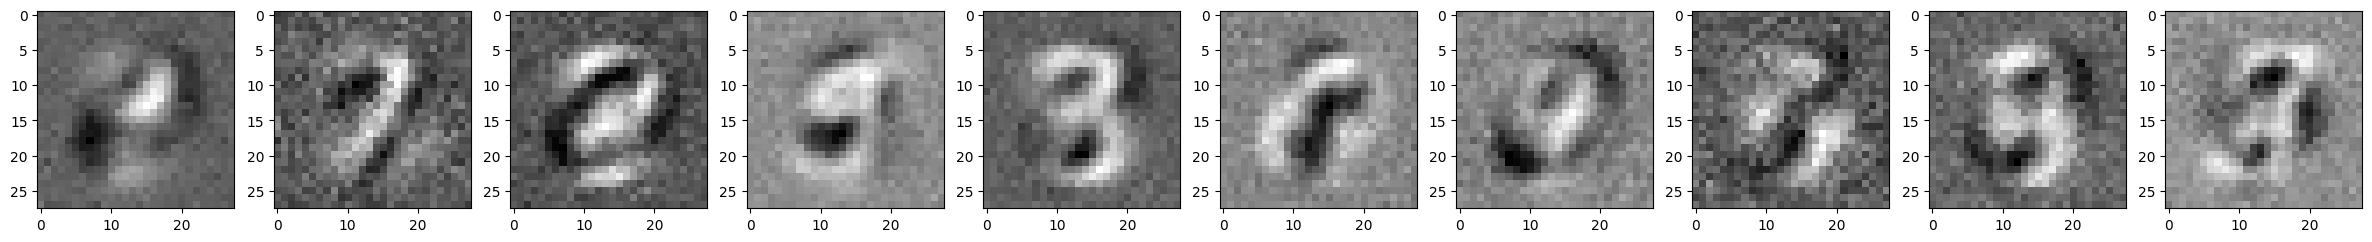

In [82]:
def generate_samples(model, num, beta, alpha_bar):
    T= len(beta)
    with torch.no_grad():
        Xs =  torch.normal(0.0,1.0,size=(num,1, 28, 28),dtype=torch.float32, device=device)
        for t in reversed(range(T)):
            eps_model = model(Xs, t*torch.ones(num).to(device))
            std_model = beta[t] / torch.sqrt(1-alpha_bar[t])
            mu = (Xs-eps_model*std_model)/torch.sqrt(1-beta[t])
            Xs = mu + torch.normal(0., 1., size=(num, 1, 28, 28), device=device) * torch.sqrt(beta[t])
    return Xs

num = 10
samples = generate_samples(model, num, beta, alpha_bar)

fig, ax = plt.subplots(ncols=num)
for i in range(10):
    ax[i].imshow(samples[i].cpu().squeeze(),cmap='gray')

fig.set_size_inches(30,30)
plt.savefig("diffusion_model_generate_samples.png")
fig.show()

# beta = 0.02: train loss 2.56
# beta beta = np.linspace(0.00001, 0.02, T) loss: 6.52
# beta beta = np.linspace(0.0001, 0.02, T) loss: 6.7
# t_embed_dim=100 beta = 0.02 2.19
# T=500 loss: 1.5